In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os
import time
from unidecode import unidecode
import warnings
from mplsoccer.pitch import Pitch
import seaborn as sns
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [13]:
match_html_path = r"C:\Users\K Raghunandan\Analyst\Matches\Liverpool 1-2 Manchester United - Premier League 2025_2026 Live.html"
fotmob_matchId = 4813449

def extract_json_from_html(html_path, save_output=False):
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()

    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for JSON parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save JSON data to txt
        output_file = open(f"{html_path}.txt", "wt", encoding='utf-8')
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

def get_short_name(full_name):
    if pd.isna(full_name):
        return full_name
    parts = full_name.split()
    if len(parts) == 1:
        return full_name  # No need for short name if there's only one word
    elif len(parts) == 2:
        return parts[0][0] + ". " + parts[1]
    else:
        return parts[0][0] + ". " + parts[1][0] + ". " + " ".join(parts[2:])

json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

df = pd.DataFrame(events_dict)
dfp = pd.DataFrame(players_df)
dfp['shortName'] = dfp['name'].apply(get_short_name)

In [14]:
df.columns

Index(['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'relatedEventId', 'relatedPlayerId', 'goalMouthZ', 'goalMouthY',
       'isGoal', 'isShot', 'blockedX', 'blockedY', 'cardType'],
      dtype='object')

In [15]:
dfp.columns

Index(['playerId', 'shirtNo', 'name', 'position', 'height', 'weight', 'age',
       'isFirstEleven', 'isManOfTheMatch', 'field', 'stats',
       'subbedInPlayerId', 'subbedOutPeriod', 'subbedOutExpandedMinute',
       'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId',
       'teamId', 'shortName'],
      dtype='object')

In [16]:
df['type'] = df['type'].str.extract(r"'displayName': '([^']+)")
df['outcomeType'] = df['outcomeType'].str.extract(r"'displayName': '([^']+)")
df['period'] = df['period'].str.extract(r"'displayName': '([^']+)")

In [17]:
df['teamName'] = df['teamId'].map(teams_dict)
team_names = list(teams_dict.values())
opposition_dict = {team_names[i]: team_names[1-i] for i in range(len(team_names))}
df['oppositionTeamName'] = df['teamName'].map(opposition_dict)

In [18]:
df['x'] = df['x']*1.2
df['y'] = df['y']*0.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*0.8
df['goalMouthY'] = df['goalMouthY']*0.8

In [19]:
columns_to_drop = ['height', 'weight', 'age', 'isManOfTheMatch', 'field', 'stats', 
                   'subbedInPlayerId', 'subbedOutPeriod', 
                   'subbedOutExpandedMinute', 'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId', 
                   'teamId']
dfp.drop(columns=columns_to_drop, inplace=True)

In [20]:
df = df.merge(dfp, on='playerId', how='left')

In [21]:
df.columns

Index(['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'relatedEventId', 'relatedPlayerId', 'goalMouthZ', 'goalMouthY',
       'isGoal', 'isShot', 'blockedX', 'blockedY', 'cardType', 'teamName',
       'oppositionTeamName', 'shirtNo', 'name', 'position', 'isFirstEleven',
       'shortName'],
      dtype='object')

In [22]:
df

,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,...,blockedX,blockedY,cardType,teamName,oppositionTeamName,shirtNo,name,position,isFirstEleven,shortName
0,2.861461e+09,3,0,0.0,32,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Liverpool,NaN,NaN,NaN,NaN,NaN
1,2.861461e+09,3,0,0.0,26,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Liverpool,Man Utd,NaN,NaN,NaN,NaN,NaN
2,2.861461e+09,4,0,0.0,32,60.00,40.00,0,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Liverpool,19.0,Bryan Mbeumo,AMC,True,B. Mbeumo
3,2.861462e+09,5,0,3.0,32,28.92,39.60,0,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Liverpool,31.0,Senne Lammens,GK,True,S. Lammens
4,2.861462e+09,6,0,7.0,32,71.16,75.28,0,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Liverpool,2.0,Diogo Dalot,DML,True,D. Dalot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2.861588e+09,935,98,44.0,26,0.00,0.00,103,NaN,NaN,...,NaN,NaN,NaN,Liverpool,Man Utd,NaN,NaN,NaN,NaN,NaN
1468,2.861588e+09,730,0,0.0,32,0.00,0.00,13,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Liverpool,NaN,NaN,NaN,NaN,NaN
1469,2.861588e+09,936,0,0.0,26,0.00,0.00,13,NaN,NaN,...,NaN,NaN,NaN,Liverpool,Man Utd,NaN,NaN,NaN,NaN,NaN
1470,2.861384e+09,2,0,0.0,32,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Man Utd,Liverpool,NaN,NaN,NaN,NaN,NaN


In [23]:
dfp

,playerId,shirtNo,name,position,isFirstEleven,shortName
0,401633,25,Giorgi Mamardashvili,GK,True,G. Mamardashvili
1,424945,12,Conor Bradley,DR,True,C. Bradley
2,345957,5,Ibrahima Konaté,DC,True,I. Konaté
3,95408,4,Virgil van Dijk,DC,True,V. v. Dijk
4,424273,6,Milos Kerkez,DL,True,M. Kerkez
5,345319,10,Alexis Mac Allister,DMC,True,A. M. Allister
6,363884,38,Ryan Gravenberch,DMC,True,R. Gravenberch
7,108226,11,Mohamed Salah,AMR,True,M. Salah
8,369875,8,Dominik Szoboszlai,AMC,True,D. Szoboszlai
9,352825,18,Cody Gakpo,AML,True,C. Gakpo


In [24]:
df = df[
    ((df['x'].notna()) & 
    (df['y'].notna()) & 
    (df['endX'].notna()) & 
    (df['endY'].notna())) | 
    ((df['x'].notna()) & 
    (df['y'].notna()) & 
    (df['goalMouthY'].notna()))
]

In [25]:
df=df.reset_index()

In [26]:
df

,index,id,eventId,minute,second,teamId,x,y,expandedMinute,period,...,blockedX,blockedY,cardType,teamName,oppositionTeamName,shirtNo,name,position,isFirstEleven,shortName
0,2,2.861461e+09,4,0,0.0,32,60.00,40.00,0,NaN,...,NaN,NaN,NaN,Man Utd,Liverpool,19.0,Bryan Mbeumo,AMC,True,B. Mbeumo
1,3,2.861462e+09,5,0,3.0,32,28.92,39.60,0,NaN,...,NaN,NaN,NaN,Man Utd,Liverpool,31.0,Senne Lammens,GK,True,S. Lammens
2,6,2.861462e+09,7,0,8.0,32,71.16,75.28,0,NaN,...,NaN,NaN,NaN,Man Utd,Liverpool,2.0,Diogo Dalot,DML,True,D. Dalot
3,7,2.861462e+09,6,0,18.0,26,31.80,0.00,0,NaN,...,NaN,NaN,NaN,Liverpool,Man Utd,12.0,Conor Bradley,DR,True,C. Bradley
4,8,2.861462e+09,7,0,20.0,26,29.16,9.28,0,NaN,...,NaN,NaN,NaN,Liverpool,Man Utd,10.0,Alexis Mac Allister,DMC,True,A. M. Allister
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,1453,2.861587e+09,928,97,47.0,26,37.44,22.56,102,NaN,...,NaN,NaN,NaN,Liverpool,Man Utd,5.0,Ibrahima Konaté,DC,True,I. Konaté
992,1456,2.861587e+09,930,97,50.0,26,75.96,23.12,102,NaN,...,NaN,NaN,NaN,Liverpool,Man Utd,4.0,Virgil van Dijk,DC,True,V. v. Dijk
993,1461,2.861588e+09,932,98,26.0,26,49.92,14.56,103,NaN,...,NaN,NaN,NaN,Liverpool,Man Utd,25.0,Giorgi Mamardashvili,GK,True,G. Mamardashvili
994,1462,2.861588e+09,933,98,31.0,26,65.16,7.36,103,NaN,...,NaN,NaN,NaN,Liverpool,Man Utd,8.0,Dominik Szoboszlai,AMC,True,D. Szoboszlai


In [28]:
df=df[["minute","second","x","y","endX","endY","teamName","shirtNo","position","shortName","goalMouthY","isShot","isGoal"]]

In [29]:
df

,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,0,0.0,60.00,40.00,28.92,39.60,Man Utd,19.0,AMC,B. Mbeumo,NaN,NaN,NaN
1,0,3.0,28.92,39.60,71.16,75.28,Man Utd,31.0,GK,S. Lammens,NaN,NaN,NaN
2,0,8.0,71.16,75.28,81.24,80.00,Man Utd,2.0,DML,D. Dalot,NaN,NaN,NaN
3,0,18.0,31.80,0.00,30.00,8.56,Liverpool,12.0,DR,C. Bradley,NaN,NaN,NaN
4,0,20.0,29.16,9.28,36.60,12.32,Liverpool,10.0,DMC,A. M. Allister,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,97,47.0,37.44,22.56,75.96,23.12,Liverpool,5.0,DC,I. Konaté,NaN,NaN,NaN
992,97,50.0,75.96,23.12,69.96,22.64,Liverpool,4.0,DC,V. v. Dijk,NaN,NaN,NaN
993,98,26.0,49.92,14.56,63.72,8.32,Liverpool,25.0,GK,G. Mamardashvili,NaN,NaN,NaN
994,98,31.0,65.16,7.36,76.20,21.84,Liverpool,8.0,AMC,D. Szoboszlai,NaN,NaN,NaN


In [31]:
df.to_csv('players.csv', index=False)

In [32]:
df.shortName.unique()

array(['B. Mbeumo', 'S. Lammens', 'D. Dalot', 'C. Bradley',
       'A. M. Allister', 'Casemiro', 'M. Mount', 'M. Cunha', 'L. Shaw',
       'H. Maguire', 'M. d. Ligt', 'V. v. Dijk', 'B. Fernandes',
       'A. Diallo', 'D. Szoboszlai', 'M. Kerkez', 'G. Mamardashvili',
       'I. Konaté', 'C. Gakpo', 'R. Gravenberch', 'M. Salah', 'A. Isak',
       'M. Ugarte', 'P. Dorgu', 'B. Sesko', 'H. Ekitiké', 'F. Wirtz',
       'C. Jones', 'F. Chiesa', 'J. Frimpong', 'L. Yoro', 'K. Mainoo'],
      dtype=object)

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_16420\1828687724.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


41


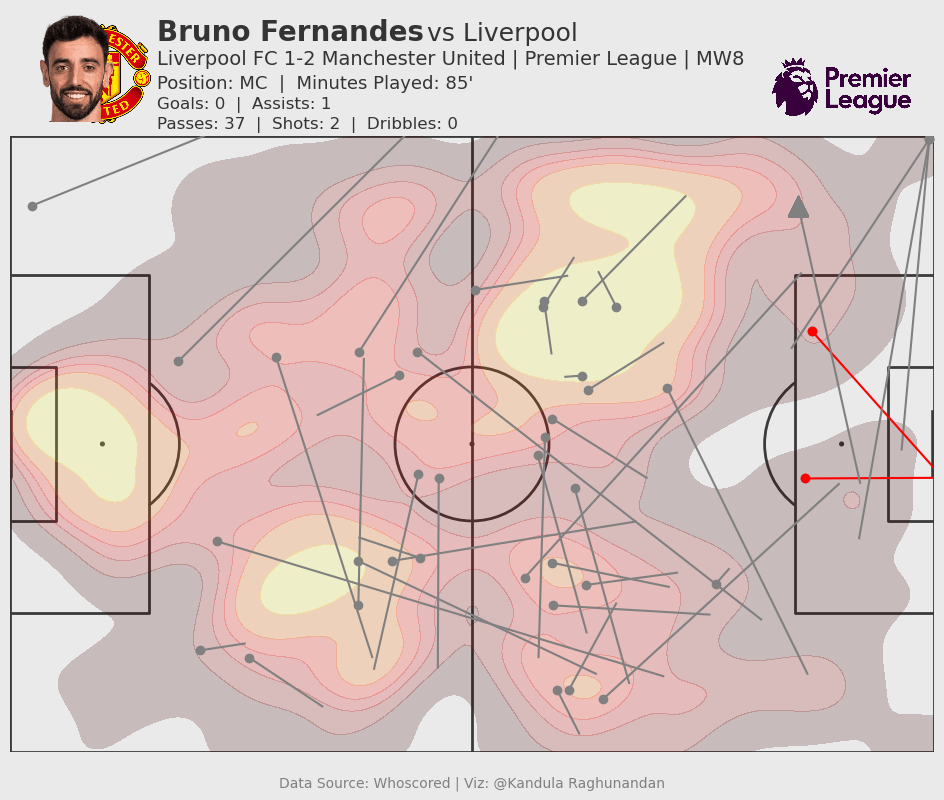

In [125]:
#Bruno
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="B. Fernandes":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="B. Fernandes") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    if (df["isGoal"][843]==True):
        plt.scatter(df["x"][842],df["y"][842],color="#808080",marker="^",s=200)
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="B. Fernandes"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Bruno Fernandes", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.475,1,"vs Liverpool", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Liverpool FC 1-2 Manchester United | Premier League | MW8", 
         fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: MC  |  Minutes Played: 85'", 
         fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Bruno Fernandes.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 0  |  Assists: 1", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 37  |  Shots: 2  |  Dribbles: 0", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Liverpool 1-2 Manchester United - Premier League 2025_2026 Live_files\Bruno.jpg",bbox_inches='tight')

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_16420\741045519.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


28


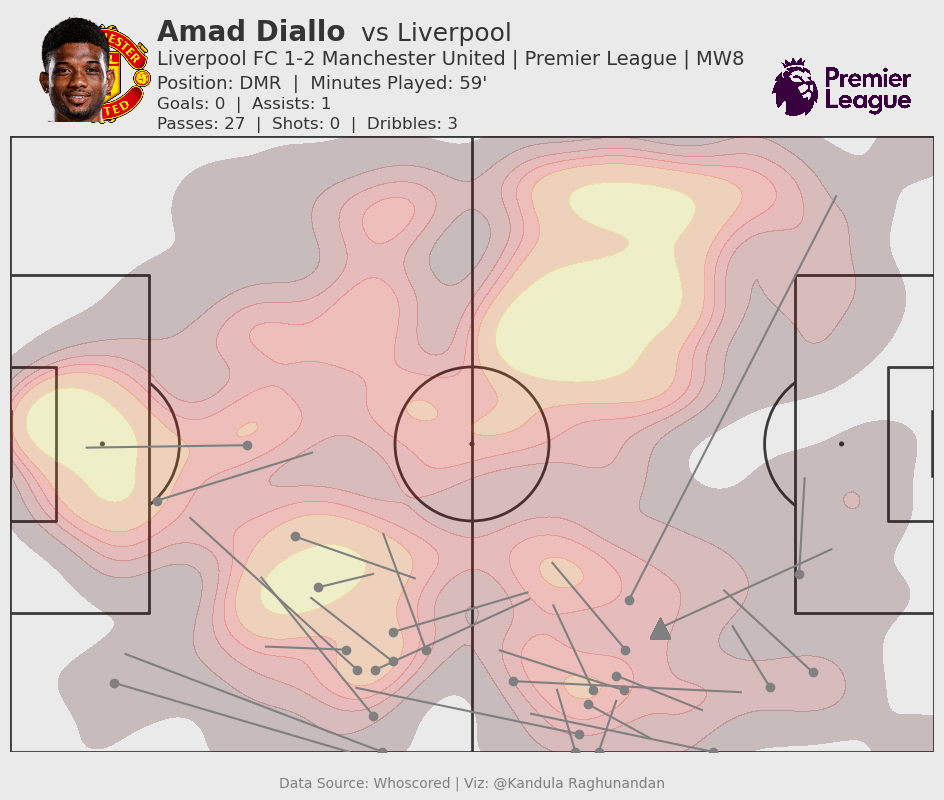

In [126]:
#Amad
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="A. Diallo":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="A. Diallo") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    if (df["isGoal"][20]==True):
        plt.scatter(df["x"][19],df["y"][19],color="#808080",marker="^",s=200)
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="A. Diallo"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Amad Diallo", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.42,1,"vs Liverpool", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Liverpool FC 1-2 Manchester United | Premier League | MW8", 
         fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: DMR  |  Minutes Played: 59'", 
         fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Amad Diallo.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 0  |  Assists: 1", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 27  |  Shots: 0  |  Dribbles: 3", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Liverpool 1-2 Manchester United - Premier League 2025_2026 Live_files\Amad.jpg",bbox_inches='tight')

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_16420\77924093.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


22


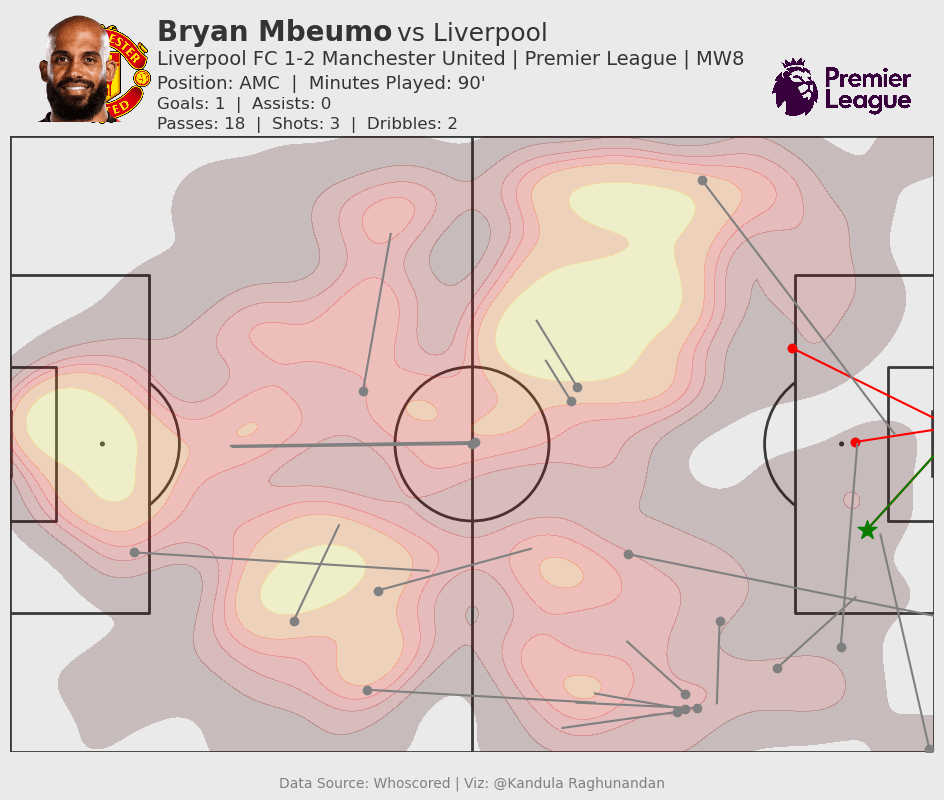

In [127]:
#Mbeumo
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="B. Mbeumo":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="B. Mbeumo") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    #if (df["isGoal"][x]==True):
        #plt.scatter(df["x"][x],df["y"][x],color="#808080",marker="^",s=200)
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="B. Mbeumo"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Bryan Mbeumo", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.45,1,"vs Liverpool", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Liverpool FC 1-2 Manchester United | Premier League | MW8", 
         fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: AMC  |  Minutes Played: 90'", 
         fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Mbeumo.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 1  |  Assists: 0", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 18  |  Shots: 3  |  Dribbles: 2", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Liverpool 1-2 Manchester United - Premier League 2025_2026 Live_files\Mbeumo.jpg",bbox_inches='tight')

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_16420\905206769.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


31


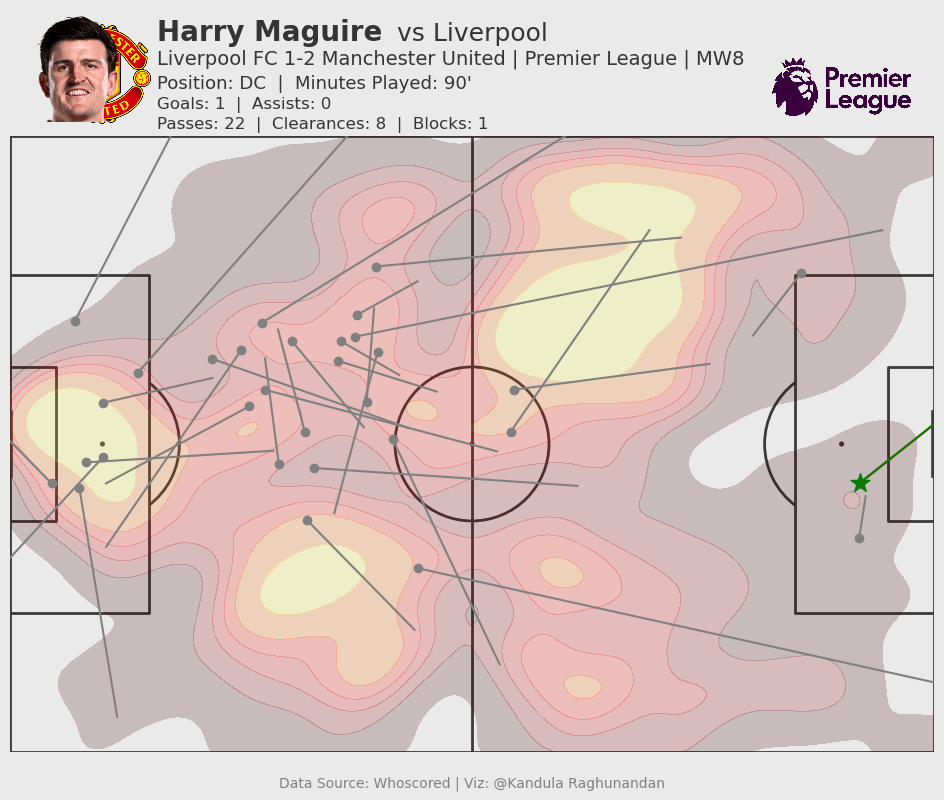

In [128]:
#Maguire
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=0.5,
    n_levels=7,
    cmap="hot"
)

count=0

for x in range(len(df["x"])):
    #Passes
    if df["shortName"][x]=="H. Maguire":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="#808080")
        plt.scatter(df["x"][x],df["y"][x],color="#808080")
        count=count+1

    #Shots
    if (df["shortName"][x]=="H. Maguire") & (df["isShot"][x]==True):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="red")
        plt.scatter(df["x"][x],df["y"][x],color="red")
        
    #Assists
    #if (df["isGoal"][x]==True):
        #plt.scatter(df["x"][x],df["y"][x],color="#808080",marker="^",s=200)
        #print(x)
        
    #Goals
    if (df["isGoal"][x]==True) & (df["shortName"][x]=="H. Maguire"):
        plt.plot((df["x"][x],120),(df["y"][x],df["goalMouthY"][x]),color="Green")
        plt.scatter(df["x"][x],df["y"][x],color="Green",marker="*",s=200)

print(count)

fig.text(0.25, 1, "Harry Maguire", fontsize=20, fontweight='bold', color='#343434')
fig.text(0.45,1,"vs Liverpool", fontsize = 18, color="#343434")
fig.text(0.25, 0.97, "Liverpool FC 1-2 Manchester United | Premier League | MW8", 
         fontsize=14, color='#343434')
fig.text(0.25, 0.94, "Position: DC  |  Minutes Played: 90'", 
         fontsize=13, color='#343434')

team_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester United.png")
player_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Players/Maguire.png")
league_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/PREM LOGO (2).png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, team_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, player_logo, zoom=0.4, xy=(0.072, 1.11))
add_logo(ax,league_logo,zoom=0.05, xy=(0.9,1.08))

fig.text(0.25, 0.915, "Goals: 1  |  Assists: 0", fontsize=12, color='#343434')
fig.text(0.25, 0.89, "Passes: 22  |  Clearances: 8  |  Blocks: 1", fontsize=12, color='#343434')

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Liverpool 1-2 Manchester United - Premier League 2025_2026 Live_files\Maguire.jpg",bbox_inches='tight')